In [1]:
import os
os.chdir('/mnt/mint_files/TCC/main_code/')

In [2]:
import numpy as np
from tensorflow import keras
from pyrsgis import raster
from pyrsgis.convert import changeDimension
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from glob import glob

2023-01-26 02:13:21.655329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-26 02:13:21.655353: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [43]:
# Assign file names
mxBangalore = 'images/bangalore_data/l5_Bangalore2011_raw.tif'
builtupBangalore = 'images/bangalore_data/l5_Bangalore2011_builtup.tif'
mxHyderabad = 'images/bangalore_data/l5_Hyderabad2011_raw.tif'

# Read the rasters as array
ds1, featuresBangalore = raster.read(mxBangalore, bands='all')
ds2, labelBangalore = raster.read(builtupBangalore, bands=1)
ds3, featuresHyderabad = raster.read(mxHyderabad, bands='all')

# Print the size of the arrays
print("Bangalore Multispectral image shape: ", featuresBangalore.shape)
print("Bangalore Binary built-up image shape: ", labelBangalore.shape)
print("Hyderabad Multispectral image shape: ", featuresHyderabad.shape)


Bangalore Multispectral image shape:  (6, 2054, 2044)
Bangalore Binary built-up image shape:  (2054, 2044)
Hyderabad Multispectral image shape:  (6, 1318, 1056)


In [44]:
# lê as imagens do Recreio
# imagesPath = glob("/home/danieljm/Documentos/imagens_para_tcc/landsart8/LO82170762021268CUB00_B[1-6].TIF")
# imagesPath.sort()
# recreioBands = []
# for i in imagesPath:
#   recreioBands.append(raster.read(i))

# bandsList = []
# for i in recreioBands:
#     bandsList.append(i[1])
# imagesCombinedAray = np.array(bandsList)
# imagesCombinedAray.shape
# recreioFile = 'images/lagoa_freitas/2015/lagoa_freitas_v1_multiband_6.TIF'
recreioFile = 'images/lagoa_freitas/2015/lagoa_freitas_v2_multiband_6.TIF'
recreioDs, recreioFeatures = raster.read(recreioFile, bands='all')
print("Recreio multispectral image shape: ", recreioFeatures.shape)

Recreio multispectral image shape:  (6, 200, 150)


In [45]:
# Clean the labelled data to replace NoData values by zero
labelBangalore = (labelBangalore == 1).astype(int)

# Reshape the array to single dimensional array
featuresBangalore = changeDimension(featuresBangalore)
labelBangalore = changeDimension (labelBangalore)
featuresHyderabad = changeDimension(featuresHyderabad)
nBands = featuresBangalore.shape[1]

print("Bangalore Multispectral image shape: ", featuresBangalore.shape)
print("Bangalore Binary built-up image shape: ", labelBangalore.shape)
print("Hyderabad Multispectral image shape: ", featuresHyderabad.shape)

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
Bangalore Multispectral image shape:  (4198376, 6)
Bangalore Binary built-up image shape:  (4198376,)
Hyderabad Multispectral image shape:  (1391808, 6)


In [46]:
# reshape as bandas do Recreio
featuresRecreio = changeDimension(recreioFeatures)
featuresRecreio.shape

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.


(30000, 6)

In [47]:
# Split testing and training datasets
xTrain, xTest, yTrain, yTest = train_test_split(featuresBangalore, labelBangalore, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(2519025, 6)
(2519025,)
(1679351, 6)
(1679351,)


In [48]:
# Normalise the data
xTrain = xTrain / 255.0 # bits
xTest = xTest / 255.0
featuresHyderabad = featuresHyderabad / 255.0

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
featuresHyderabad = featuresHyderabad.reshape((featuresHyderabad.shape[0], 1, featuresHyderabad.shape[1]))

# Print the shape of reshaped data
print(xTrain.shape, xTest.shape, featuresHyderabad.shape)

(2519025, 1, 6) (1679351, 1, 6) (1391808, 1, 6)


In [49]:
# Normalize Recreio
featuresRecreio = featuresRecreio / 65535.0 # 16 bits

# reshape
featuresRecreio = featuresRecreio.reshape((featuresRecreio.shape[0], 1, featuresRecreio.shape[1]))
print(featuresRecreio.shape)

(30000, 1, 6)


In [73]:
# Escolhe as bandas para serem utilizadas. entre 0 e 5. alterar a quantidade na primeira camada da RN
# [1,2,3] -> bands 2,3,4 - RGB
# [2,3,4] -> bands 3,4,5 - Infra vermelho
# [1,4,5] -> bands 2,5,6 - Agricultura
# [0,2,3] -> bands 1,3,4 - Bathymetric
xTrain_b = xTrain[:,:,[0,2,3]]
xTest_b = xTest[:,:,[0,2,3]]
featuresRecreio_b = featuresRecreio[:,:,[0,2,3]]

In [74]:
# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, 3)), #input_shape=(1, nBands)
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')]) #softmax

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain_b, yTrain, epochs=2)

Epoch 1/2
78720/78720 [==============================] - 48s 607us/step - loss: 0.1370 - accuracy: 0.9491
Epoch 2/2
78720/78720 [==============================] - 47s 602us/step - loss: 0.1111 - accuracy: 0.9580


In [83]:
# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix) #antes era 14
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[1448877   31999]
 [  37554  160921]]

P-Score: 0.834, R-Score: 0.811


In [13]:
predicted = model.predict(featuresHyderabad)
predicted

array([[0.9424035 , 0.05759643],
       [0.920965  , 0.07903495],
       [0.93557316, 0.06442682],
       ...,
       [0.9989617 , 0.00103826],
       [0.9629383 , 0.03706167],
       [0.12017326, 0.8798268 ]], dtype=float32)

In [75]:
recreioPredicted = model.predict(featuresRecreio_b)
recreioPredicted

array([[0.7291882 , 0.27081183],
       [0.6946473 , 0.3053527 ],
       [0.68864226, 0.31135777],
       ...,
       [0.77431554, 0.22568448],
       [0.6989003 , 0.30109972],
       [0.7646518 , 0.2353482 ]], dtype=float32)

In [84]:
predictVisualizacao = recreioPredicted[:,1]

# Calculate and display the error metrics
resultPredict = (predictVisualizacao>0.10).astype(int)

In [85]:
from PIL import Image as im
print(resultPredict)
print(resultPredict.shape)
arrayOfnumeros = np.array(resultPredict)
# (360, 500) - lagoa v1
# (200, 150) - lagoa v2
arrayOfnumeros = np.reshape(arrayOfnumeros, (200, 150))
data = im.fromarray((arrayOfnumeros*255).astype(np.uint8))
data.save('images/output/rn/result_rn_b134_10_v2.png')

[1 1 1 ... 1 1 1]
(30000,)


In [ ]:

predicted = predicted[:,1]

# Predict new data and export the probability raster
prediction = np.reshape(predicted, (ds3.RasterYSize, ds3.RasterXSize))
outFile = 'images/output/Hyderabad_2011_BuiltupNN_predicted_14_nodes_softplus.tif'
raster.export(prediction, ds3, filename=outFile, dtype='float')

Band count: 1
Image resolution h =  1318 , w =  1056
CRS:  EPSG:32644
Bounds (georeferencing):  BoundingBox(left=213615.0, bottom=1906185.0, right=245295.0, top=1945725.0)


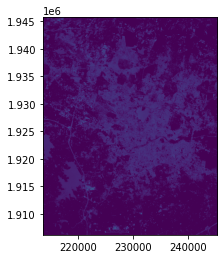

<AxesSubplot:>

In [ ]:
import rasterio as rs
from rasterio.plot import show

filename = 'images/output/Hyderabad_2011_BuiltupNN_predicted_14_nodes_softplus.tif'
dataset = rs.open(filename)
print('Band count:', dataset.count)
print('Image resolution h = ', dataset.height, ', w = ', dataset.width)
print('CRS: ', dataset.crs)
print('Bounds (georeferencing): ', dataset.bounds)
show(dataset)

In [ ]:

recreioPredicted = recreioPredicted[:,1]

outFileRecreio = 'images/output/lagoa_freitas_predicted_rn_14_nodes_softplus.TIF'
recreioPrediction = np.reshape(recreioPredicted, (recreioDs.RasterYSize, recreioDs.RasterXSize))
raster.export(recreioPrediction, recreioDs, filename=outFileRecreio, dtype='float')

In [ ]:
import rasterio as rs
from rasterio.plot import show

filename = 'images/output/lagoa_freitas_predicted_rn_14_nodes_softplus.TIF'
datasetRecreio = rs.open(filename)
print('Band count:', datasetRecreio.count)
print('Image resolution h = ', datasetRecreio.height, ', w = ', datasetRecreio.width)
print('CRS: ', datasetRecreio.crs)
print('Bounds (georeferencing): ', datasetRecreio.bounds)
show(datasetRecreio)

TypeError: '>' not supported between instances of 'DatasetReader' and 'float'

In [ ]:
rSmallPredicted = rSmallPredicted[:,1]
outFileRecreioSmall = 'images/recreio_small_predicted_1.TIF'
recreioSmallPrediction = np.reshape(rSmallPredicted, (rSmallDS.RasterYSize, rSmallDS.RasterXSize))
raster.export(recreioSmallPrediction, rSmallDS, filename=outFileRecreioSmall, dtype='float')


Band count: 1
Image resolution h =  50 , w =  50
CRS:  EPSG:32623
Bounds (georeferencing):  BoundingBox(left=546585.0, bottom=-2441085.0, right=548085.0, top=-2439585.0)


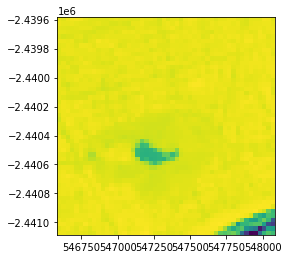

<AxesSubplot:>

In [ ]:
import rasterio as rs
from rasterio.plot import show

datasetRecreioSmall = rs.open('images/recreio_small_predicted_1.TIF')
print('Band count:', datasetRecreioSmall.count)
print('Image resolution h = ', datasetRecreioSmall.height, ', w = ', datasetRecreioSmall.width)
print('CRS: ', datasetRecreioSmall.crs)
print('Bounds (georeferencing): ', datasetRecreioSmall.bounds)
show(datasetRecreioSmall)

In [ ]:
rBigPredicted = rBigPredicted[:,1]
recreioBigPrediction = np.reshape(rBigPredicted, (rBigDS.RasterYSize, rBigDS.RasterXSize))
raster.export(recreioBigPrediction, rBigDS, filename='images/recreio_big_predicted_1.TIF', dtype='float')

Band count: 1
Image resolution h =  200 , w =  500
CRS:  EPSG:32623
Bounds (georeferencing):  BoundingBox(left=546585.0, bottom=-2445585.0, right=561585.0, top=-2439585.0)


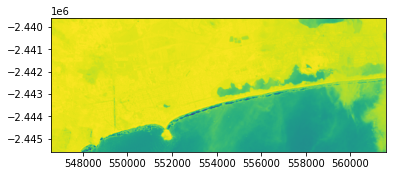

<AxesSubplot:>

In [ ]:
import rasterio as rs
from rasterio.plot import show

datasetRecreioBig = rs.open('images/recreio_big_predicted_1.TIF')
print('Band count:', datasetRecreioBig.count)
print('Image resolution h = ', datasetRecreioBig.height, ', w = ', datasetRecreioBig.width)
print('CRS: ', datasetRecreioBig.crs)
print('Bounds (georeferencing): ', datasetRecreioBig.bounds)
show(datasetRecreioBig)

Band count: 6
Image resolution h =  1318 , w =  1056
CRS:  EPSG:32644
Bounds (georeferencing):  BoundingBox(left=213615.0, bottom=1906185.0, right=245295.0, top=1945725.0)


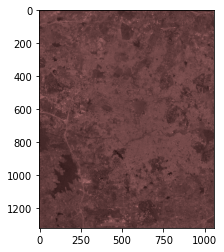

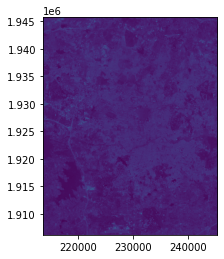

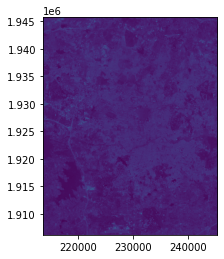

<AxesSubplot:>

In [ ]:
import rasterio as rs
from rasterio.plot import show
from matplotlib import pyplot

dataset = rs.open('images/l5_Hyderabad2011_raw.tif')
print('Band count:', dataset.count)
print('Image resolution h = ', dataset.height, ', w = ', dataset.width)
print('CRS: ', dataset.crs)
print('Bounds (georeferencing): ', dataset.bounds)

pyplot.imshow(dataset.read(1), cmap='pink')
pyplot.show()
show(dataset)
show(dataset.read(1), transform=dataset.transform)

Band count: 1
Image resolution h =  2054 , w =  2044
CRS:  EPSG:32643
Bounds (georeferencing):  BoundingBox(left=752893.9818, bottom=1405185.0, right=814213.9818, top=1466805.0)


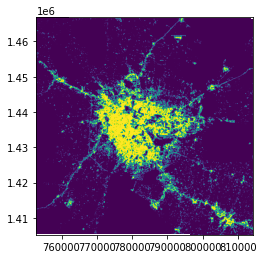

<AxesSubplot:>

In [ ]:
import rasterio as rs
from rasterio.plot import show
from matplotlib import pyplot

dataset = rs.open('images/l5_Bangalore2011_builtup.tif')
print('Band count:', dataset.count)
print('Image resolution h = ', dataset.height, ', w = ', dataset.width)
print('CRS: ', dataset.crs)
print('Bounds (georeferencing): ', dataset.bounds)

show(dataset)


In [ ]:
a3 = dataset.read(1)
a3

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

Band count: 6
Image resolution h =  1318 , w =  1056
CRS:  EPSG:32644
Bounds (georeferencing):  BoundingBox(left=213615.0, bottom=1906185.0, right=245295.0, top=1945725.0)


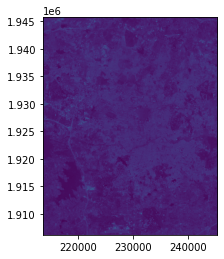

<AxesSubplot:>

In [ ]:
mxHyderabad
dataset = rs.open(mxHyderabad)
print('Band count:', dataset.count)
print('Image resolution h = ', dataset.height, ', w = ', dataset.width)
print('CRS: ', dataset.crs)
print('Bounds (georeferencing): ', dataset.bounds)
show(dataset)

In [ ]:
imagesPath = glob("images/teste_recreio_v2_B[2-7].TIF")
imagesPath.sort()
imagesPath

['images/teste_recreio_v2_B2.TIF',
 'images/teste_recreio_v2_B3.TIF',
 'images/teste_recreio_v2_B4.TIF',
 'images/teste_recreio_v2_B5.TIF',
 'images/teste_recreio_v2_B6.TIF',
 'images/teste_recreio_v2_B7.TIF']

In [ ]:
bandsRecreio = []
for i in imagesPath:
  bandsRecreio.append(raster.read(i))
bandsRecreio

[(<pyrsgis.raster.createDS at 0x7f41f818e100>,
  array([[ 9807, 10558,  9186, ..., 11933, 11564, 11552],
         [ 9099,  9580,  8983, ..., 11525, 12475, 12420],
         [ 9039,  9035,  8990, ..., 12699, 12780, 13232],
         ...,
         [10888, 11371, 12174, ..., 10718, 10677, 10710],
         [11328, 11545, 12273, ..., 10687, 10802, 10784],
         [11500, 11520, 12297, ..., 10637, 10811, 10817]], dtype=int16)),
 (<pyrsgis.raster.createDS at 0x7f41f818e790>,
  array([[ 8815, 10260,  8423, ..., 11167, 10846, 10971],
         [ 8005,  8584,  8005, ..., 10351, 11513, 11750],
         [ 7858,  7904,  7870, ..., 11425, 11866, 12582],
         ...,
         [10254, 10540, 11200, ...,  9342,  9380,  9330],
         [10093, 10776, 11426, ...,  9198,  9156,  9307],
         [10461, 11077, 11655, ...,  9165,  9182,  9326]], dtype=int16)),
 (<pyrsgis.raster.createDS at 0x7f41f818e1f0>,
  array([[ 8025,  9919,  7233, ..., 10681, 10423, 10275],
         [ 6999,  7842,  6895, ..., 10095, 11

In [ ]:
bandsList = []
for i in bandsRecreio:
    bandsList.append(i[1])
bandsRecreioCombined = np.array(bandsList)
bandsRecreioCombined.shape

(6, 110, 200)